<a href="https://colab.research.google.com/github/JAleAguileraMarvik/fruad-prex/blob/main/XGBoost_fraud_prex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
#Ruta del archivo
nombre_archivo = '/content/drive/My Drive/Colab Notebooks/Fraud-prex/Base.csv'

In [8]:
#Lectura del archivo
datos = pd.read_csv(nombre_archivo)

In [9]:
datos.head(5)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [10]:
#Contar nulos - Desbalanceo de clases
nulos_en_fraud_bool = datos['fraud_bool'].isnull().sum()

# Valores 0 y 1 en 'fraud_bool'
ocurrencias_0 = (datos['fraud_bool'] == 0).sum()
ocurrencias_1 = (datos['fraud_bool'] == 1).sum()

print("Valores nulos en 'fraud_bool':", nulos_en_fraud_bool)
print("Cantidad de ocurrencias de 0 en 'fraud_bool':", ocurrencias_0)
print("Cantidad de ocurrencias de 1 en 'fraud_bool':", ocurrencias_1)

Valores nulos en 'fraud_bool': 0
Cantidad de ocurrencias de 0 en 'fraud_bool': 988971
Cantidad de ocurrencias de 1 en 'fraud_bool': 11029


In [15]:
#One Hot-Encoded
datos_encoded = pd.get_dummies(datos, columns=['payment_type','housing_status'])
bool_columns = datos_encoded.select_dtypes(include=['bool']).columns
datos_encoded[bool_columns] = datos_encoded[bool_columns].astype(int)

In [28]:
datos_encoded.head(5)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,payment_type_AC,payment_type_AD,payment_type_AE,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,...,0,0,0,0,0,1,0,0,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,...,0,1,0,0,0,1,0,0,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,...,0,0,0,0,0,1,0,0,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,...,0,0,0,0,0,1,0,0,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,...,0,0,0,0,0,1,0,0,0,0


In [29]:
#Calculo de correlación
datos_numericos_encoded = datos_encoded.select_dtypes(include=['float64', 'int64'])

correlaciones_encoded = datos_numericos_encoded.corr()
print(correlaciones_encoded)

                                  fraud_bool    income  name_email_similarity  \
fraud_bool                          1.000000  0.045079              -0.036720   
income                              0.045079  1.000000              -0.038519   
name_email_similarity              -0.036720 -0.038519               1.000000   
prev_address_months_count          -0.026031  0.018209              -0.018186   
current_address_months_count        0.033701 -0.036985               0.050305   
customer_age                        0.062959  0.125822              -0.048902   
days_since_request                  0.000567 -0.015877              -0.007736   
intended_balcon_amount             -0.024524  0.059046               0.029040   
zip_count_4w                        0.005212 -0.080581               0.025114   
velocity_6h                        -0.016892 -0.096431               0.024881   
velocity_24h                       -0.011183 -0.101269               0.035221   
velocity_4w                 

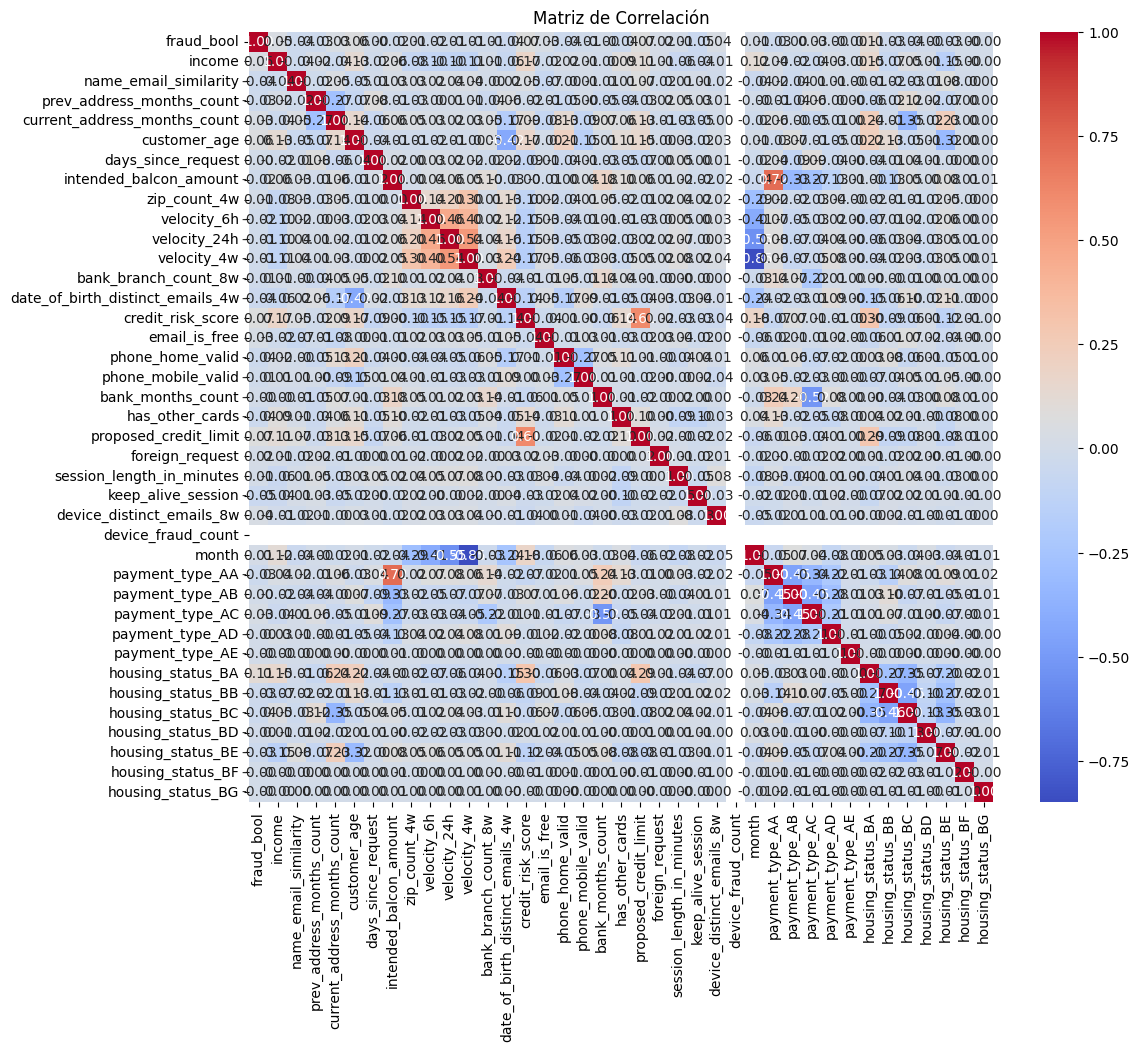

In [30]:
# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlaciones_encoded, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [32]:
#XG-Boost ONLY
X = datos_encoded[['name_email_similarity', 'income', 'date_of_birth_distinct_emails_4w', 'bank_branch_count_8w', 'credit_risk_score',
           'zip_count_4w', 'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'credit_risk_score', 'email_is_free','phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request',
       'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w',  'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
          'payment_type_AE']].values
y = datos_encoded['fraud_bool'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

#Métricas
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.989385
Confusion Matrix:
[[197812     79]
 [  2044     65]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197891
           1       0.45      0.03      0.06      2109

    accuracy                           0.99    200000
   macro avg       0.72      0.52      0.53    200000
weighted avg       0.98      0.99      0.98    200000



In [34]:
#XGBoost con Oversamplig SMOTE
X = datos_encoded[['name_email_similarity', 'income', 'date_of_birth_distinct_emails_4w', 'bank_branch_count_8w', 'credit_risk_score',
                   'zip_count_4w', 'prev_address_months_count', 'current_address_months_count',
                   'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
                   'velocity_4w', 'bank_branch_count_8w',
                   'credit_risk_score', 'email_is_free', 'phone_mobile_valid', 'bank_months_count',
                   'has_other_cards', 'proposed_credit_limit', 'foreign_request',
                   'session_length_in_minutes', 'keep_alive_session',
                   'device_distinct_emails_8w', 'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
                   'payment_type_AE']].values
y = datos_encoded['fraud_bool'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entrenar el modelo de XGBoost con los datos balanceados
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_resampled, y_train_resampled)

# Evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.989335
Confusion Matrix:
[[197816     75]
 [  2058     51]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197891
           1       0.40      0.02      0.05      2109

    accuracy                           0.99    200000
   macro avg       0.70      0.51      0.52    200000
weighted avg       0.98      0.99      0.98    200000



In [35]:
# Contar las clases en y_train_resampled
clases = np.bincount(y_train_resampled)

# Imprimir las clases y sus frecuencias
print(f'Clase 0 (No fraude): {clases[0]} ejemplos')
print(f'Clase 1 (Fraude): {clases[1]} ejemplos')

Clase 0 (No fraude): 791080 ejemplos
Clase 1 (Fraude): 791080 ejemplos
